<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/SVD_inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
from matplotlib.image import imread
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
import cv2 as cv
from sklearn.decomposition import SparseCoder

# load image

In [4]:
def read_image(image_path):
    return io.imread(image_path)

# Gray level

In [5]:
def convert_to_grayscale(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return image
    return color.rgb2gray(image)


# mask

In [7]:
def create_mask(image_shape, mask_coords):
    mask = np.zeros(image_shape, dtype=bool)
    for (x, y, w, h) in mask_coords:
        mask[y:y+h, x:x+w] = True
    return mask


# patches

In [ ]:

def extract_patches(image, patch_size):
    patches = view_as_windows(image, (patch_size, patch_size), step=patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)
    return patches

In [48]:
def display_images(original_image, masked_image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('on')

    axs[1].imshow(masked_image, cmap='gray')
    axs[1].set_title('Masked Image')
    axs[1].axis('on')

    plt.show()

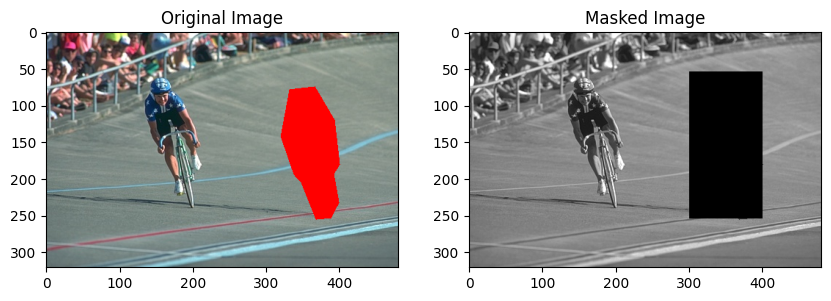

In [51]:
def main(image_path, mask_coords,  k):
    original_image = read_image(image_path)
    grayscale_image = convert_to_grayscale(original_image)
    mask = create_mask(grayscale_image.shape, mask_coords)
    masked_image = np.copy(grayscale_image)
    masked_image[mask] = 0

    display_images(original_image, masked_image)

# Example Usage
image_path = '22.png'
mask_coords = [(300, 55, 100, 200)]  # Example coordinates (x, y, width, height)
k = 50  # Top k% singular values to keep for SVD or top k principal components for PCA
main(image_path, mask_coords, k)
